In [1]:
from tensorflow.keras import preprocessing
from tensorflow.keras import Sequential
from tensorflow.keras.layers import experimental
import matplotlib.pyplot as plt

In [29]:
image_size = (300, 300)
batch_size = 35

In [30]:
train = preprocessing.image_dataset_from_directory(
    "../dataset/train/",
    image_size=image_size,
    batch_size=batch_size
)

test = preprocessing.image_dataset_from_directory(
    "../dataset/test/",
    image_size=image_size,
    batch_size=batch_size
)

Found 498 files belonging to 2 classes.
Found 500 files belonging to 2 classes.


In [31]:
augmentation = Sequential([
    experimental.preprocessing.RandomFlip("horizontal"),
    experimental.preprocessing.RandomRotation(0.1),
])

In [32]:
train = train.prefetch(buffer_size=40)
test = test.prefetch(buffer_size=40)

In [33]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dropout, SeparableConv2D
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import L2

In [34]:
inputs = Input(shape=image_size+(3,))

x = augmentation(inputs)

x = experimental.preprocessing.Rescaling(1.0/255)(x)

x = Conv2D(32, 3, strides=2, padding='same', activation='relu')(x)
x = MaxPooling2D(2)(x)
x = BatchNormalization()(x)

x = Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=L2())(x)
x = MaxPooling2D(2)(x)
x = BatchNormalization()(x)

x = SeparableConv2D(126, 3, padding='same', activation='relu', kernel_regularizer=L2())(x)
x = MaxPooling2D(2)(x)
x = BatchNormalization()(x)

x = SeparableConv2D(126, 3, padding='same', activation='relu', kernel_regularizer=L2())(x)
x = MaxPooling2D(2)(x)
x = BatchNormalization()(x)

x = Conv2D(256, 3, padding='same', activation='relu', kernel_regularizer=L2())(x)
x = MaxPooling2D(2)(x)
x = BatchNormalization()(x)

x = Flatten()(x)

x = Dropout(0.5)(x)
x = Dense(126, activation='relu')(x)

x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)

x = Dense(1, activation='sigmoid')(x)

model = Model(inputs, x)
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 300, 300, 3)       0         
_________________________________________________________________
rescaling_5 (Rescaling)      (None, 300, 300, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 75, 75, 32)        128       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 75, 75, 64)        1849

In [35]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(), loss='mse', metrics=['accuracy'])

Epoch 1/1000
15/15 [==============================] - 16s 992ms/step - loss: 2.3775 - accuracy: 0.5663 - val_loss: 2.1910 - val_accuracy: 0.5000
Epoch 2/1000
15/15 [==============================] - 11s 726ms/step - loss: 2.1360 - accuracy: 0.6285 - val_loss: 1.9899 - val_accuracy: 0.5000
Epoch 3/1000
15/15 [==============================] - 14s 912ms/step - loss: 1.9279 - accuracy: 0.6245 - val_loss: 1.7692 - val_accuracy: 0.5000
Epoch 4/1000
15/15 [==============================] - 14s 906ms/step - loss: 1.6978 - accuracy: 0.6265 - val_loss: 1.5784 - val_accuracy: 0.5000
Epoch 5/1000
15/15 [==============================] - 13s 855ms/step - loss: 1.5466 - accuracy: 0.6345 - val_loss: 1.4153 - val_accuracy: 0.5000
Epoch 6/1000
15/15 [==============================] - 12s 770ms/step - loss: 1.3422 - accuracy: 0.6667 - val_loss: 1.2985 - val_accuracy: 0.5000
Epoch 7/1000
15/15 [==============================] - 13s 840ms/step - loss: 1.2108 - accuracy: 0.6687 - val_loss: 1.1539 - val_ac

15/15 [==============================] - 12s 820ms/step - loss: 0.1863 - accuracy: 0.8936 - val_loss: 0.3310 - val_accuracy: 0.6580

Epoch 00055: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 56/1000
15/15 [==============================] - 13s 834ms/step - loss: 0.1827 - accuracy: 0.8956 - val_loss: 0.3227 - val_accuracy: 0.6760
Epoch 57/1000
15/15 [==============================] - 13s 826ms/step - loss: 0.1646 - accuracy: 0.9217 - val_loss: 0.3175 - val_accuracy: 0.6900
Epoch 58/1000
15/15 [==============================] - 13s 843ms/step - loss: 0.1751 - accuracy: 0.8976 - val_loss: 0.3098 - val_accuracy: 0.7040
Epoch 59/1000
15/15 [==============================] - 12s 816ms/step - loss: 0.1749 - accuracy: 0.9096 - val_loss: 0.3093 - val_accuracy: 0.6940
Epoch 60/1000
15/15 [==============================] - 13s 824ms/step - loss: 0.1652 - accuracy: 0.9317 - val_loss: 0.3152 - val_accuracy: 0.6880
Epoch 61/1000
15/15 [==============================] - 13s

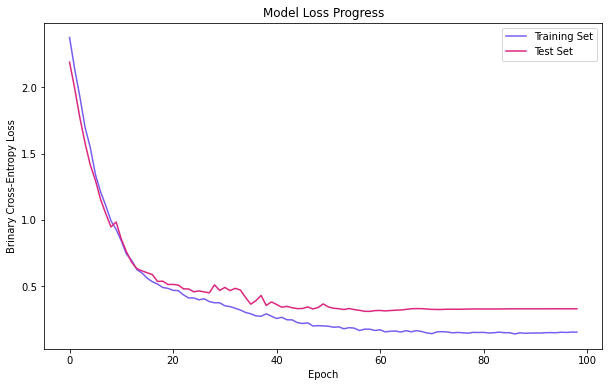

In [36]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

hist = model.fit(train, validation_data=test, batch_size=40, epochs=1000, callbacks=[
    ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_delta=1e-2, mode='min', verbose=1),
    EarlyStopping(monitor='val_loss', patience=40, min_delta=1e-5, restore_best_weights=True, verbose=1)
])

fig = plt.figure(figsize=(10,6))
plt.plot(hist.history['loss'], color='#785ef0')
plt.plot(hist.history['val_loss'], color='#dc267f')
plt.title('Model Loss Progress')
plt.ylabel('Brinary Cross-Entropy Loss')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Test Set'], loc='upper right')
plt.show()

In [10]:
model.save('./model.hdf5')

In [8]:
from tensorflow.keras.models import load_model

model = load_model('./model.hdf5')

In [40]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
img = img_to_array(load_img('./IMG_20210725_215537.jpg',target_size=(200, 200)))
img.shape

(200, 200, 3)

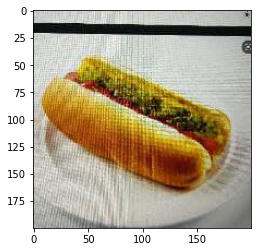

In [38]:
plt.imshow(img.astype('float32')/255)

In [41]:
model.predict(np.array([img]))

ValueError: in user code:

    /home/angel/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1569 predict_function  *
        return step_function(self, iterator)
    /home/angel/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1559 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/angel/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/angel/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/angel/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/angel/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1552 run_step  **
        outputs = model.predict_step(data)
    /home/angel/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1525 predict_step
        return self(x, training=False)
    /home/angel/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1013 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/angel/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:267 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer model_5: expected shape=(None, 300, 300, 3), found shape=(None, 200, 200, 3)


In [30]:
import tensorflow as tf

In [34]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmply9fgb47/assets


In [36]:
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)